In [27]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import textwrap
import datetime as dt

# import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# extras
%matplotlib inline
import xoak

# import personal modules
# Path to modules
sys.path.append('../../modules')
# Import my modules
from ar_funcs import AR_rank

In [32]:
server='comet'
# Set up paths
if server == 'skyriver':
    path_to_data = '/work/dnash/data/'      # project data -- read only
else:
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
path_to_out  = '../../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../../figs/'      # figures


### Data from all notebooks (TODO: make yaml dict)

In [29]:
ext1 = [-141., -130., 54., 61.] # extent of SEAK 

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl1 = ['Hoonah', 'Skagway', 'Haines', 'Yakutat', 'Klawock', 'Ketchikan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']
stn_lst = lbl2

### Read mesowest precipitation data

In [33]:
df_lst = []
for i, stn in enumerate(stn_lst): 

    filename = path_to_data + 'downloads/mesowest/{0}.csv'.format(stn_lst[i])
    df = pd.read_csv(filename, header=6, skiprows=[7], sep=',', engine='python',
                          parse_dates=['Date_Time'])
    # Converting the index as date (need to do this to utilize functionality of resample)
    df.index = pd.to_datetime(df.Date_Time)

    ## Precip from gauges is in precipitation accumulation (inch) in one hour, measured every ~5 min
    # Need to convert to precip accumulated (mm) each minute measured each x minutes
    # divide by 60 (minutes in an hour) and multiply by x minutes (delta time (mins) between t-1 and t)

    df['precip_accum_one_hour_set_1'].fillna(0) # fill nans with 0
    df['delta'] = (df['Date_Time']-df['Date_Time'].shift()).fillna(pd.Timedelta('0 minutes')) # calculate the difference between the time steps
    df['ans'] = df['delta'].apply(lambda x: x  / np.timedelta64(1,'m')).astype('int64') # calculate the difference between the time steps
    df['prec_hrly'] = ((df.precip_accum_one_hour_set_1/60.0)*df.ans)*25.4 # divide by 60 (to covert to minutes) and multiple by delta minutes
    tmp = df['prec_hrly'].resample('1H').mean()
    
    df_lst.append(tmp)

### Load Stage IV data

In [49]:
date_lst = pd.date_range('2020-11-28 00', '2020-12-07 00', freq='6H')
ds_lst = []
for i, date in enumerate(date_lst):
    ## load data 
    fname = '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/stage_IV/st4_ak.2020{:02}{:02}{:02}.06h.grb2'.format(date.month, date.day, date.hour)
    ds = xr.load_dataset(fname, engine="cfgrib")
    
    # add time as a dimension
    ds = ds.expand_dims(dim={"valid_time": 1})
    da = ds.tp
    
    ds_lst.append(da)
    
stg4 = xr.combine_by_coords(ds_lst)
## rename lat, lon, prec
d = {'latitude': 'lat', 'longitude':'lon', 'tp': 'prec'}
stg4 = stg4.rename(d)
stg4

Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/stage_IV/st4_ak.2020112800.06h.grb2.923a8.idx' older than GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/stage_IV/st4_ak.2020112806.06h.grb2.923a8.idx' older than GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/stage_IV/st4_ak.2020112812.06h.grb2.923a8.idx' older than GRIB file
Ignoring index file '/cw3e/mead/projects/cwp140/scratch/dnash/data/downloads/stage_IV/st4_ak.2020112818.06h.grb2.923a8.idx' older than GRIB file


<xarray.Dataset>
Dimensions:     (valid_time: 37, y: 530, x: 460)
Coordinates:
    time        (valid_time) datetime64[ns] 2020-11-27T18:00:00 ... 2020-12-0...
    step        timedelta64[ns] 06:00:00
    surface     float64 0.0
    lat         (y, x) float64 45.85 45.87 45.9 45.93 ... 75.61 75.65 75.68
    lon         (y, x) float64 212.0 212.0 212.1 212.1 ... 207.2 207.3 207.4
  * valid_time  (valid_time) datetime64[ns] 2020-11-28 ... 2020-12-07
Dimensions without coordinates: y, x
Data variables:
    prec        (valid_time, y, x) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Load IMERG-PM Data

In [38]:
# %%time

# def preprocess(ds):
#     '''keep only selected lats and lons'''
#     return ds.sel(lat=slice(ext1[2], ext1[3]), lon=slice(ext1[0], ext1[1]))

# # List GPM filenames
# fname_pattern = '/work/dnash/data/downloads/IMERG-PM/3B-HHR.MS*.nc4'

# gpm = xr.open_mfdataset(fname_pattern, engine='netcdf4', concat_dim='time', combine='nested',
#                            preprocess=preprocess)

# print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
# gpm = gpm.transpose('lat', 'lon', 'time')
# gpm = gpm.rename({'precipitationCal': 'prec'})
# gpm = gpm.resample(time='1H').mean()
# gpm = gpm.sel(time=slice('2020-11-28 00', '2020-12-03 23'))

# # # fix time
# # datetimeindex = gpm.indexes['time'].to_datetimeindex()
# # gpm['time'] = datetimeindex
# # print('ds size in GB {:0.2f}\n'.format(gpm.nbytes / 1e9))
# # gpm = gpm.load()

# ## test plot 1 time step of daily data
# import cartopy.crs as ccrs
# ax = plt.axes(projection=ccrs.PlateCarree())
# test = gpm.sel(time='2020-12-01 06:00:00').prec
# test
# test.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
# ax.coastlines()

In [39]:
# ### pull precip time series from gpm data
# diff_lat = gpm.lat.values[2] - gpm.lat.values[1]
# diff_lon = gpm.lon.values[2] - gpm.lon.values[1]
# dxdy = 1.0
# # select the grid cell closest to each of the communities
# df_lst2 = []
# df_lst3 = []
# row_lbl2 = []
# for i, (slon, slat) in enumerate(zip(xs2, ys2)):
#     # select nearest grid cell to station
#     # ds = gpm.sel(lat=slat, lon=slon, method="nearest")
#     # df = ds.prec.to_dataframe()
#     # df_lst2.append(df)
    
#     ## TODO: select 9 nearest grid cells
#     ds = gpm.sel(lat=slice(slat-diff_lat*dxdy, slat+diff_lat*dxdy), lon=slice(slon-diff_lon*dxdy, slon+diff_lon*dxdy))
#     ds = ds.max(("lon", "lat"))
#     df = ds.prec.to_dataframe()
#     df_lst2.append(df)

#     # make nice labels for plot
#     lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(slat, slon*-1)
#     row_lbl2.append(lbl)

In [50]:
# select the grid cell closest to each of the communities
df_lst2 = []
row_lbl2 = []

for i, (slon, slat) in enumerate(zip(xs2, ys2)):
    
    ## select nearest grid cell to station for stage IV data
    points = xr.Dataset({"lat": slat, "lon": slon})
    stg4.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")
    ds = stg4.xoak.sel(lat=points.lat, lon=points.lon)
    df = ds['prec'].to_dataframe()
    df_lst2.append(df)
    
    # make nice labels for plot
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}W".format(slat, slon*-1)
    row_lbl2.append(lbl)

In [10]:
# ## merge IVT, ASOS, and GPM data
# merge_df_final = []
# for i, (df1, df2) in enumerate(zip(merge_df_lst, df_lst2)):    
    
#     tmp2 = df2.reset_index()
#     tmp2 = tmp2.rename(columns={"lat": "gpmlat", "lon": "gpmlon"})
    
    
#     merged_data = pd.merge(df1, tmp2, how='outer', on='time')
#     merged_data.index = pd.to_datetime(merged_data.time)
#     merge_df_final.append(merged_data)
    
# merge_df_final[0]

### Plot time series

In [51]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

### Get x-tick and x-labels
x_ticks = df_lst2[0].index.values

x_labels = []
for i, x in enumerate(x_ticks):
    t = pd.to_datetime(x_ticks[i])
    x_labels.append(t.strftime('%m-%d %H'))


288.1884
24.638
132.07999999999998
40.388
18.7452
54.102
2.794
51.562
nan
34.29


/tmp/ipykernel_20938/1538946915.py:21: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(df.values))


11.937999999999999
44.704


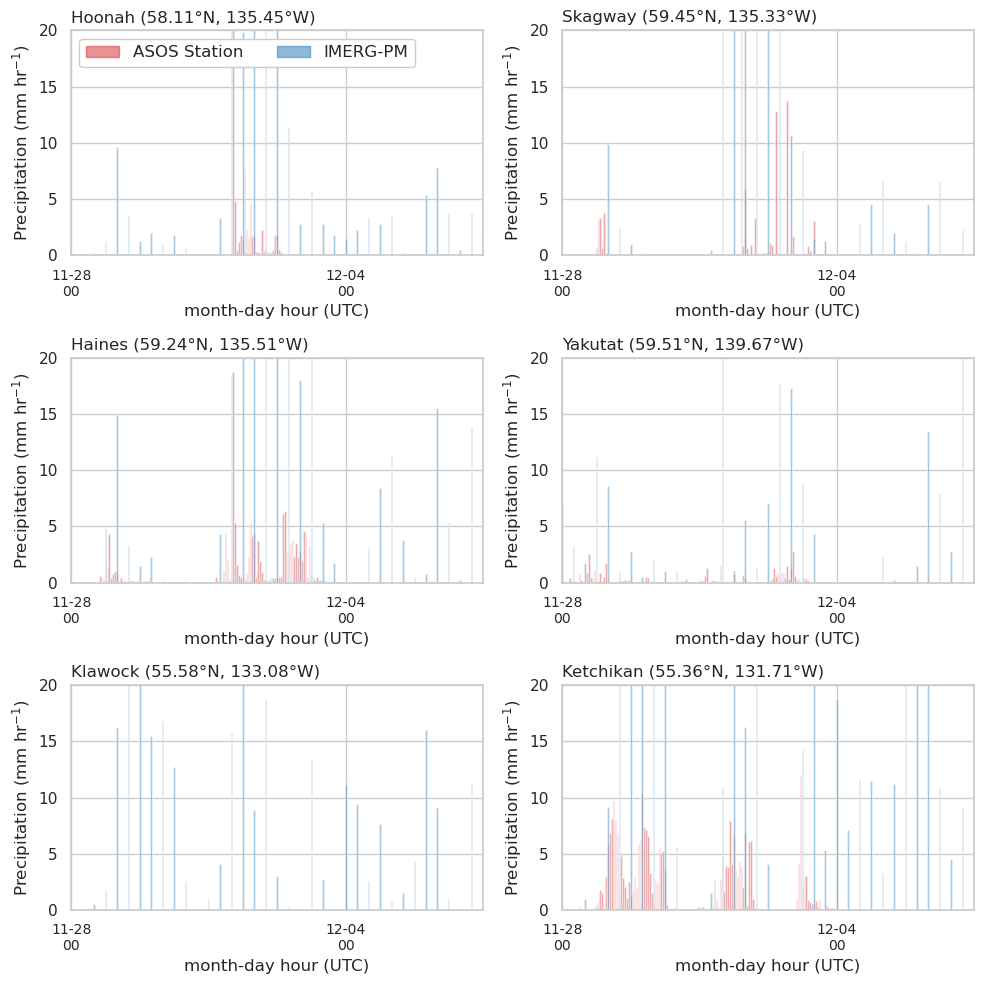

In [52]:
fname = path_to_figs + 'precip-IVT_time_series_dec2020'
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

xaxis_lbl = ['']*4 + ['month-day hour (UTC)']*2
xaxis_lbl_all = 'month-day hour (UTC)'
ylbl = ['IVT (kg m$^{-1}$ s$^{-1}$)', '']*3
ylbl_all = 'IVT (units)'
ylbl2 = ['', 'Precipitation (mm hr$^{-1}$)']*3
ylbl2_all = 'Precipitation (mm hr$^{-1}$)'

fig = plt.figure(figsize=(10,10))
sns.set_style("whitegrid")

for i, (df, df_gpm, lbl) in enumerate(zip(df_lst, df_lst2, lbl1)):
    
    ax = fig.add_subplot(nrows, ncols, i+1)
    prec = ax.bar(x=df.index, height=df.values, width=0.035, color='tab:red', alpha=0.5, align='center')
    print(np.nanmax(df.values))
    prec2 = ax.bar(x=df_gpm.index, height=df_gpm.prec, width=0.035, color='tab:blue', alpha=0.5, align='center')
    print(np.nanmax(df_gpm.prec))
    # ax.set_ylabel(ylbl2[i])
    ax.set_ylabel(ylbl2_all)
    ax.set_ylim(0, 20)
    
    ## x-axis format dates/ticks
    ax.set_xlim(df_gpm.index.min(), df_gpm.index.max())
    ax.set_xticks(x_ticks[::24]) # set the labels every 24 hours
    # ax.set_xticklabels(x_labels[::12], fontsize=10)
    ax.set_xticklabels([textwrap.fill(label, 5) for label in x_labels[::24]], fontsize=10)
    # ax2.set_xlabel(xaxis_lbl[i])
    ax.set_xlabel(xaxis_lbl_all)
    
    ax.set_title(lbl+' ({0})'.format(row_lbl2[i]), loc='left')
    
    ##Add legend
    if i == 0:
        patch0 = mpatches.Patch(color='tab:red', label='ASOS Station', alpha=0.5)
        patch1 = mpatches.Patch(color='tab:blue', label='IMERG-PM', alpha=0.5)
        ax.legend(handles=[patch0, patch1], loc='upper left', framealpha=1.0, ncol=3, fontsize=12).set_zorder(200)

    
# Save the figure
fig.tight_layout()
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)

# Show
plt.show()




In [ ]:
fname = path_to_figs + 'precip-accum_dec2020'
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

xaxis_lbl = ['']*4 + ['month-day hour (UTC)']*2
xaxis_lbl_all = 'month-day hour (UTC)'
ylbl2 = ['', 'Accumulated Precipitation (mm)']*3
ylbl2_all = 'Accumulated Precipitation (mm)'

fig = plt.figure(figsize=(10,10))
sns.set_style("whitegrid")

for i, (df, df_gpm, lbl) in enumerate(zip(df_lst, df_lst2, lbl1)):
    
    ax = fig.add_subplot(nrows, ncols, i+1)
    prec = ax.plot(df.index, df.cumsum(), color='tab:red', alpha=0.5)
    print(np.nanmax(df.values))
    prec2 = ax.plot(df_gpm.index, df_gpm.prec.cumsum(), color='tab:blue', alpha=0.5)
    # ax.set_ylabel(ylbl2[i])
    ax.set_ylabel(ylbl2_all)
    # ax.set_ylim(0, 20)
    
    ## x-axis format dates/ticks
    ax.set_xlim(df_gpm.index.min(), df_gpm.index.max())
    ax.set_xticks(x_ticks[::24]) # set the labels every 24 hours
    # ax.set_xticklabels(x_labels[::12], fontsize=10)
    ax.set_xticklabels([textwrap.fill(label, 5) for label in x_labels[::24]], fontsize=10)
    # ax2.set_xlabel(xaxis_lbl[i])
    ax.set_xlabel(xaxis_lbl_all)
    
    ax.set_title(lbl+' ({0})'.format(row_lbl2[i]), loc='left')
    
    ##Add legend
    if i == 0:
        patch0 = mpatches.Patch(color='tab:red', label='ASOS Station', alpha=0.5)
        patch1 = mpatches.Patch(color='tab:blue', label='IMERG-PM', alpha=0.5)
        ax.legend(handles=[patch0, patch1], loc='upper left', framealpha=1.0, ncol=3, fontsize=12).set_zorder(200)

    
# Save the figure
fig.tight_layout()
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)

# Show
plt.show()




288.1884
132.07999999999998
18.7452
2.794
nan
11.937999999999999


/tmp/ipykernel_20938/1245685575.py:19: RuntimeWarning: All-NaN slice encountered
  print(np.nanmax(df.values))
